In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
DIRECTORY = r"C:\Users\naimu\Music\Face-Mask-Detection\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [6]:
print("[INFO] loading images...")

[INFO] loading images...


In [7]:
data = []
labels = []

In [8]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

C:\Users\naimu\anaconda3\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [11]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [12]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator( rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [13]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [14]:
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [15]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [16]:
for layer in baseModel.layers:
    layer.trainable = False

In [17]:
print("[INFO] compiling model...")

from tensorflow.keras.optimizers import legacy

opt = legacy.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


C:\Users\naimu\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
129/129 [==============================] - 120s 903ms/step - loss: 0.3774 - accuracy: 0.8604 - val_loss: 0.1622 - val_accuracy: 0.9605
Epoch 2/20
129/129 [==============================] - 103s 802ms/step - loss: 0.1669 - accuracy: 0.9482 - val_loss: 0.1043 - val_accuracy: 0.9720
Epoch 3/20
129/129 [==============================] - 101s 784ms/step - loss: 0.1221 - accuracy: 0.9635 - val_loss: 0.0867 - val_accuracy: 0.9730
Epoch 4/20
129/129 [==============================] - 100s 779ms/step - loss: 0.1063 - accuracy: 0.9616 - val_loss: 0.0778 - val_accuracy: 0.9759
Epoch 5/20
129/129 [==============================] - 102s 791ms/step - loss: 0.0932 - accuracy: 0.9701 - val_loss: 0.0713 - val_accuracy: 0.9769
Epoch 6/20
129/129 [==============================] - 103s 798ms/step - loss: 0.0868 - accuracy: 0.9691 - val_loss: 0.0716 - val_accuracy: 0.9788
Epoch 7/20
129/129 [==============================] - 103s 796ms/step - loss: 0.0775 - accuracy: 0.9

In [19]:
# make predictions testing
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
33/33 [==============================] - 19s 544ms/step


In [20]:
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [21]:
# report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.98       520
without_mask       0.99      0.98      0.98       517

    accuracy                           0.98      1037
   macro avg       0.98      0.98      0.98      1037
weighted avg       0.98      0.98      0.98      1037



In [22]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


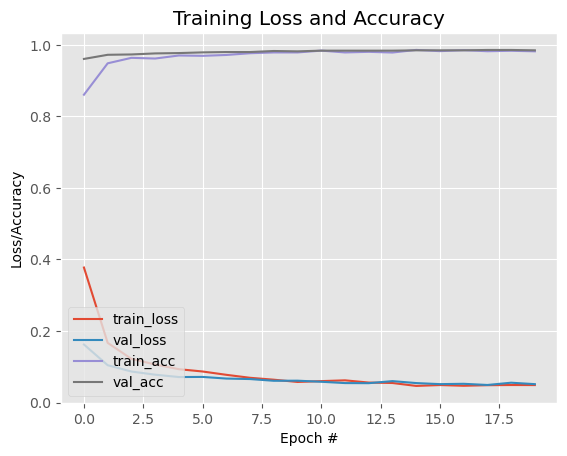

In [23]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

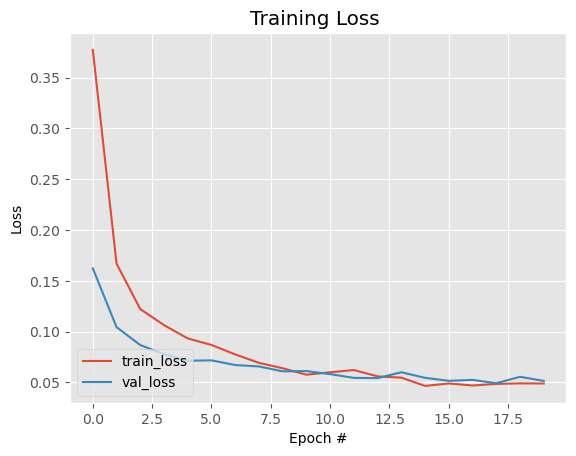

In [24]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [25]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector_TraningLoss.model", save_format="h5")

[INFO] saving mask detector model...


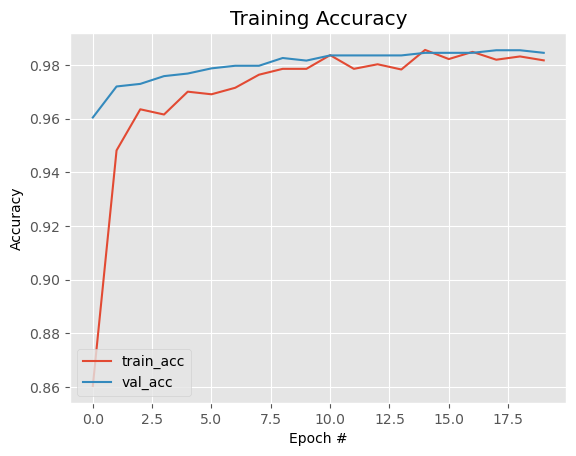

In [26]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [27]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector_train_accuracy.model", save_format="h5")

[INFO] saving mask detector model...
